In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from models import *
from data_split import *

c:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data Loading

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
# data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

In [3]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## Autoencoder multi-stage training

In [4]:
x.size()

torch.Size([124, 291])

Stage 1:

Epoch 200/2000,   	decoding loss: 6.02,    	prediction loss: 528825.12,  	reg_loss: 0.00
Epoch 400/2000,   	decoding loss: 4.52,    	prediction loss: 210475.69,  	reg_loss: 0.00
Epoch 600/2000,   	decoding loss: 3.17,    	prediction loss: 21469.41,  	reg_loss: 0.00
Epoch 800/2000,   	decoding loss: 1.90,    	prediction loss: 1071.74,  	reg_loss: 0.00
Epoch 1000/2000,   	decoding loss: 1.04,    	prediction loss: 264.28,  	reg_loss: 0.00
Epoch 1200/2000,   	decoding loss: 0.56,    	prediction loss: 142.08,  	reg_loss: 0.00
Epoch 1400/2000,   	decoding loss: 0.33,    	prediction loss: 73.89,  	reg_loss: 0.00
Epoch 1600/2000,   	decoding loss: 0.24,    	prediction loss: 45.17,  	reg_loss: 0.00
Epoch 1800/2000,   	decoding loss: 0.20,    	prediction loss: 28.68,  	reg_loss: 0.00
Epoch 2000/2000,   	decoding loss: 0.19,    	prediction loss: 27.30,  	reg_loss: 0.00

train 	 5.0159345
test 	 121.63506
sec 	 329.05606


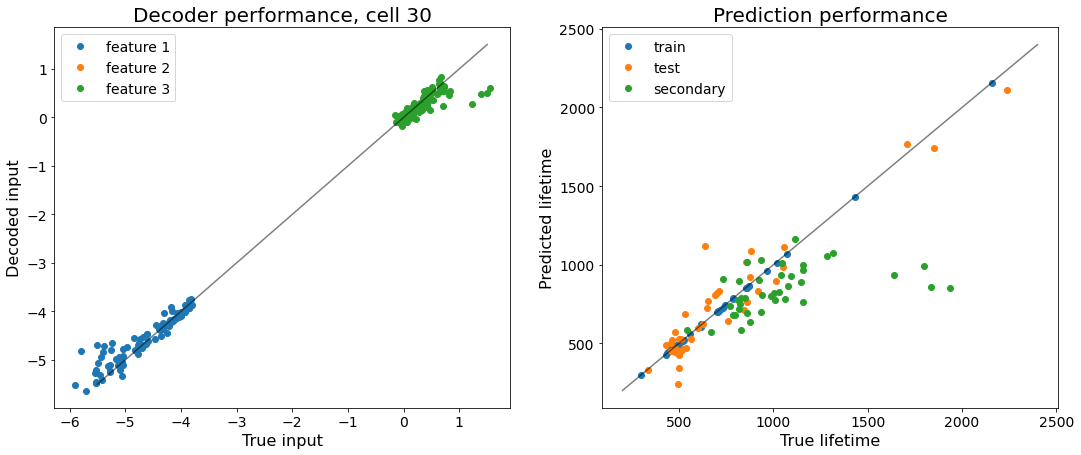

Stage 2:

Epoch 160/1600,   	decoding loss: 0.19,    	prediction loss: 15.38,  	reg_loss: 0.00
Epoch 320/1600,   	decoding loss: 0.19,    	prediction loss: 12.65,  	reg_loss: 0.00
Epoch 480/1600,   	decoding loss: 0.18,    	prediction loss: 10.14,  	reg_loss: 0.00
Epoch 640/1600,   	decoding loss: 0.18,    	prediction loss: 7.85,  	reg_loss: 0.00
Epoch 800/1600,   	decoding loss: 0.18,    	prediction loss: 5.89,  	reg_loss: 0.00
Epoch 960/1600,   	decoding loss: 0.18,    	prediction loss: 4.29,  	reg_loss: 0.00
Epoch 1120/1600,   	decoding loss: 0.18,    	prediction loss: 3.01,  	reg_loss: 0.00
Epoch 1280/1600,   	decoding loss: 0.18,    	prediction loss: 2.03,  	reg_loss: 0.00
Epoch 1440/1600,   	decoding loss: 0.18,    	prediction loss: 1.33,  	reg_loss: 0.00
Epoch 1600/1600,   	decoding loss: 0.18,    	prediction loss: 0.84,  	reg_loss: 0.00

train 	 0.91607827
test 	 127.23227
sec 	 325.5312


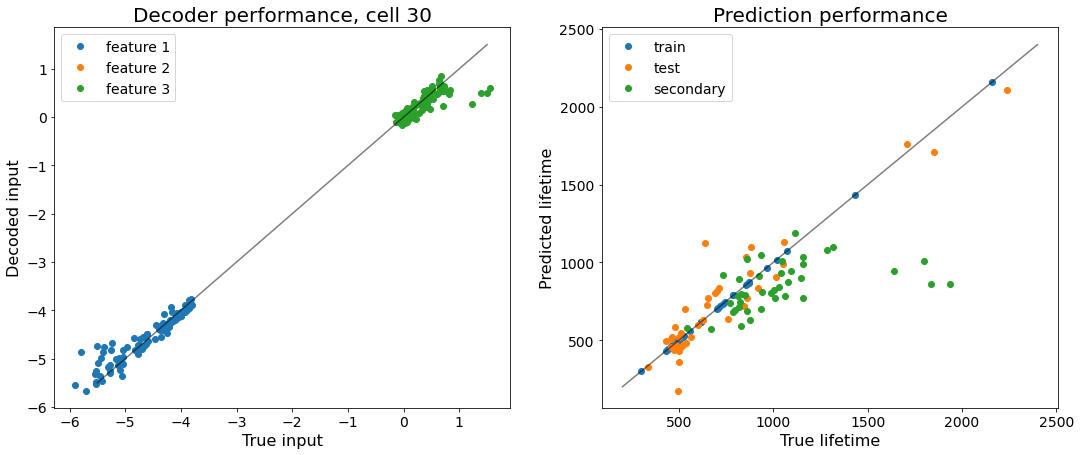

In [5]:
# del model

train_policy = {
    "num_stages": 2,
    "epochs": [2000, 1600],
    "learning_rates": [3e-5, 1e-5],
    "batch_sizes": [64, 64],
    "prediction_weights": [10, 10],
    "decoding_weights": [1, 0.00],
    "en_weights": [0.1, 0.1]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
# model.fit(train_dataset, decoding_weight=10)
# model.fit(train_dataset, prediction_weight=0.0001, decoding_weight=1, lr = 1e-5, epochs=1000)
model.fit(x, y, train_policy)

## Decoder performance on other cells

In [8]:
e = model.encoder(x[train_ind])
print(e.size())
e2 = e[...,None]
print(e2.size())
e3 = e2[..., 0]
e3.size()

torch.Size([41, 48])
torch.Size([41, 48, 1])


torch.Size([41, 48])

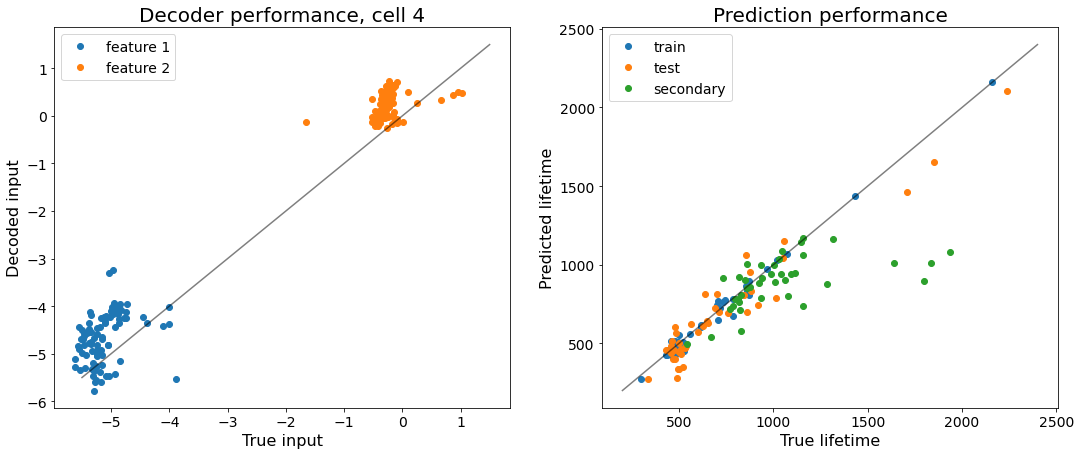

In [24]:
model.plotter(x, y, 4)

## Autoencoder with individual features

Stage 1:

Epoch 200/2000,   	decoding loss: 9.92,    	prediction loss: 536468.00,  	reg_loss: 1.40
Epoch 400/2000,   	decoding loss: 8.88,    	prediction loss: 22794.63,  	reg_loss: 1.36
Epoch 600/2000,   	decoding loss: 8.09,    	prediction loss: 13019.08,  	reg_loss: 1.32
Epoch 800/2000,   	decoding loss: 7.24,    	prediction loss: 11617.73,  	reg_loss: 1.29
Epoch 1000/2000,   	decoding loss: 6.36,    	prediction loss: 10737.73,  	reg_loss: 1.26
Epoch 1200/2000,   	decoding loss: 5.47,    	prediction loss: 9927.81,  	reg_loss: 1.24
Epoch 1400/2000,   	decoding loss: 4.60,    	prediction loss: 9070.27,  	reg_loss: 1.23
Epoch 1600/2000,   	decoding loss: 3.76,    	prediction loss: 8280.25,  	reg_loss: 1.21
Epoch 1800/2000,   	decoding loss: 3.00,    	prediction loss: 7515.00,  	reg_loss: 1.20
Epoch 2000/2000,   	decoding loss: 2.32,    	prediction loss: 6758.88,  	reg_loss: 1.18

train 	 [82.18573]
test 	 [107.13843]
sec 	 [335.0183]


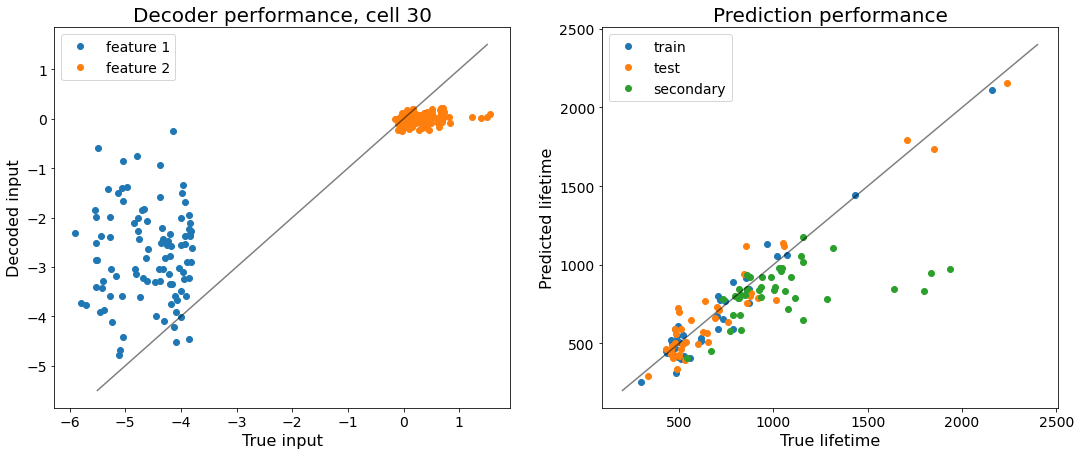

Stage 2:

Epoch 100/1000,   	decoding loss: 2.25,    	prediction loss: 6324.72,  	reg_loss: 1.19
Epoch 200/1000,   	decoding loss: 2.18,    	prediction loss: 5891.31,  	reg_loss: 1.19
Epoch 300/1000,   	decoding loss: 2.12,    	prediction loss: 5488.76,  	reg_loss: 1.19
Epoch 400/1000,   	decoding loss: 2.05,    	prediction loss: 5125.71,  	reg_loss: 1.19
Epoch 500/1000,   	decoding loss: 1.98,    	prediction loss: 4790.38,  	reg_loss: 1.20
Epoch 600/1000,   	decoding loss: 1.90,    	prediction loss: 4488.53,  	reg_loss: 1.20
Epoch 700/1000,   	decoding loss: 1.81,    	prediction loss: 4208.32,  	reg_loss: 1.20
Epoch 800/1000,   	decoding loss: 1.72,    	prediction loss: 3938.52,  	reg_loss: 1.21
Epoch 900/1000,   	decoding loss: 1.64,    	prediction loss: 3690.45,  	reg_loss: 1.21
Epoch 1000/1000,   	decoding loss: 1.56,    	prediction loss: 3457.68,  	reg_loss: 1.22

train 	 [58.7826]
test 	 [106.85053]
sec 	 [349.7949]


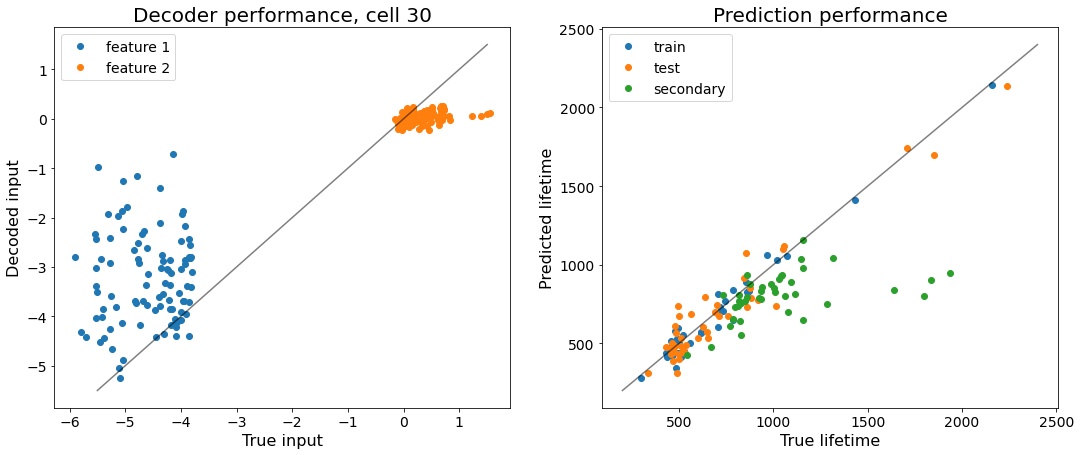

In [25]:
train_policy = {
    "num_stages": 2,
    "epochs": [2000, 1000],
    "learning_rates": [3e-5, 1e-5],
    "batch_sizes": [64, 64],
    "prediction_weights": [0.01, 0.01],
    "decoding_weights": [10, 1],
    "en_weights": [0.1, 0.1]
}


model_individual = AutoEncoder_Individual(n_features=2, n_cycles=n_cycles)
model_individual.fit(x, y, train_policy)

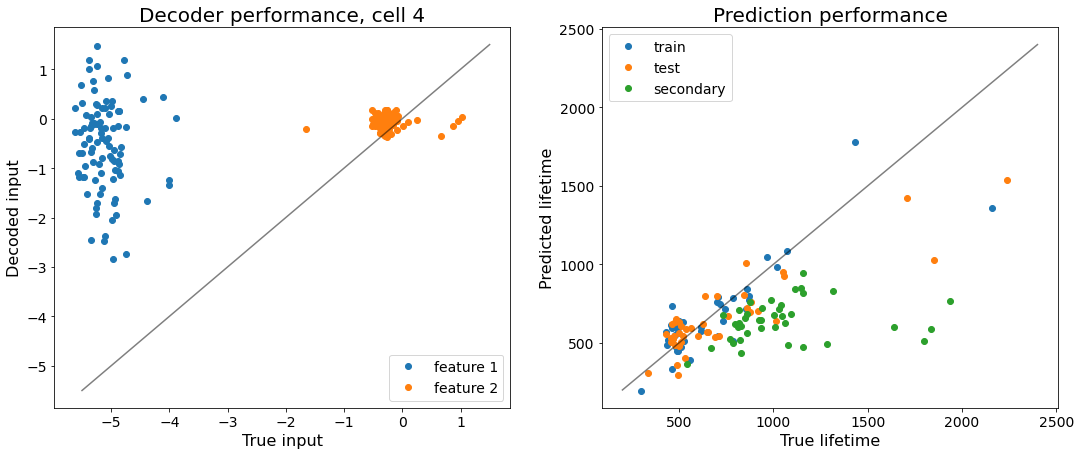

In [6]:
model_individual.plotter(x, y, 4)